In [2]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import random

frame = pd.read_csv("Stars_Types.csv")

data = pd.DataFrame()
data["temperature"] = frame["Temperature (K)"]
data["luminosity"] = frame["Luminosity (L/Lo)"]
data["radius"] = frame["Luminosity (L/Lo)"]
data["magnitude"] = frame["Absolute magnitude (Mv)"]
data["star_type"] = frame["Star type"]


In [3]:
data

,temperature,luminosity,radius,magnitude,star_type
0,3068,0.002400,0.002400,16.12,0
1,3042,0.000500,0.000500,16.60,0
2,2600,0.000300,0.000300,18.70,0
3,2800,0.000200,0.000200,16.65,0
4,1939,0.000138,0.000138,20.06,0
...,...,...,...,...,...
235,38940,374830.000000,374830.000000,-9.93,5
236,30839,834042.000000,834042.000000,-10.63,5
237,8829,537493.000000,537493.000000,-10.73,5
238,9235,404940.000000,404940.000000,-11.23,5


(array([119.,  28.,  25.,  16.,  13.,  15.,   7.,   4.,   7.,   6.]),
 array([ 1939. ,  5745.1,  9551.2, 13357.3, 17163.4, 20969.5, 24775.6,
        28581.7, 32387.8, 36193.9, 40000. ]),
 <BarContainer object of 10 artists>)

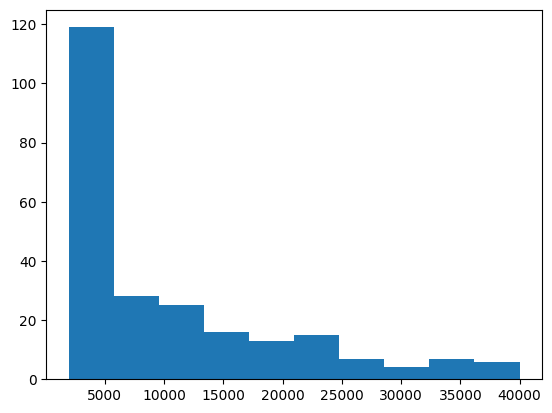

In [4]:
plt.hist(data["temperature"])

(array([155.,  15.,  33.,  13.,  11.,   1.,   4.,   2.,   2.,   4.]),
 array([8.00000000e-05, 8.49420001e+04, 1.69884000e+05, 2.54826000e+05,
        3.39768000e+05, 4.24710000e+05, 5.09652000e+05, 5.94594000e+05,
        6.79536000e+05, 7.64478000e+05, 8.49420000e+05]),
 <BarContainer object of 10 artists>)

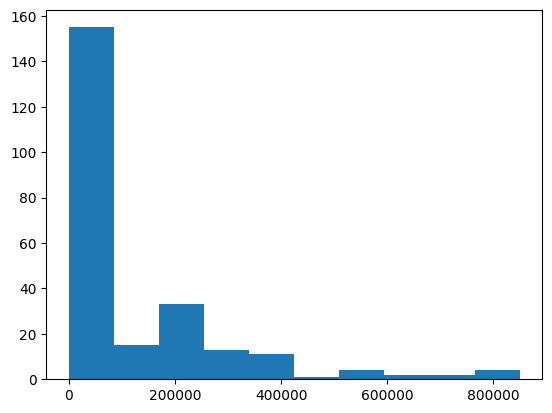

In [5]:
plt.hist(data["luminosity"])

(array([155.,  15.,  33.,  13.,  11.,   1.,   4.,   2.,   2.,   4.]),
 array([8.00000000e-05, 8.49420001e+04, 1.69884000e+05, 2.54826000e+05,
        3.39768000e+05, 4.24710000e+05, 5.09652000e+05, 5.94594000e+05,
        6.79536000e+05, 7.64478000e+05, 8.49420000e+05]),
 <BarContainer object of 10 artists>)

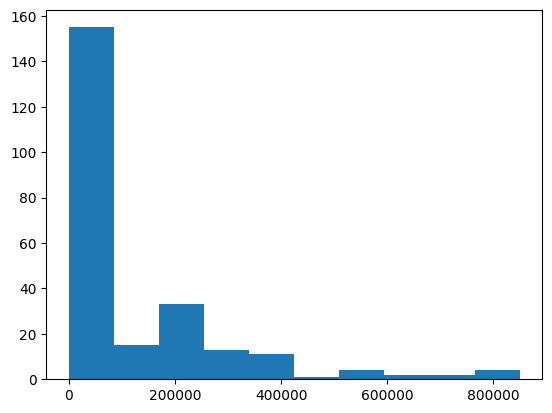

In [6]:
plt.hist(data["radius"])

(array([27., 52., 17., 10.,  6.,  8.,  3., 55., 33., 29.]),
 array([-11.92 ,  -8.722,  -5.524,  -2.326,   0.872,   4.07 ,   7.268,
         10.466,  13.664,  16.862,  20.06 ]),
 <BarContainer object of 10 artists>)

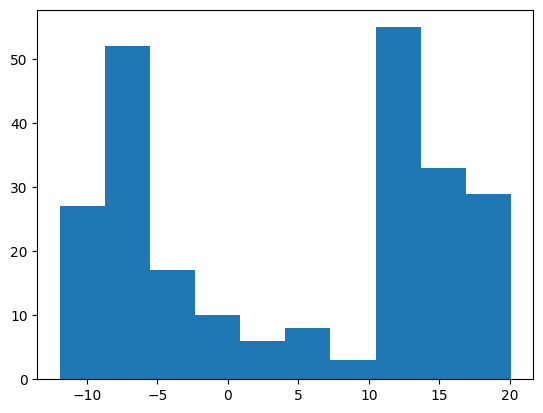

In [7]:
plt.hist(data["magnitude"])

In [8]:
#数据预处理
def min_max_normalize(x:  pd.Series):
    return (x - x.min()) / (x.max() - x.min())

#数量级差距过大，取对数
data["luminosity"] = np.log10(data["luminosity"])
data["radius"] = np.log10(data["radius"])

#标准化处理
data["temperature"] = min_max_normalize(data["temperature"])
data["luminosity"] = min_max_normalize(data["luminosity"])
data["radius"] = min_max_normalize(data["radius"])
data["magnitude"] = min_max_normalize(data["magnitude"])


In [9]:
#单层softmax回归
w = np.random.rand(6,5)
x = data.iloc[:,:4]
x.insert(0,"ones",1)
x = np.array(x.T)

t = np.array(pd.get_dummies(data["star_type"])).T

predict_func = lambda w,x: soft_max(w.dot(x))


def soft_max(x: np.ndarray) -> np.ndarray:
    x = x - np.max(x, axis=0, keepdims=True)                  
    return np.exp(x) / np.exp(x).sum(axis=0, keepdims=True)  



def MCEE(predict: np.ndarray, actual: np.ndarray):
    """平均交叉熵误差"""
    size = predict.shape[1]
    return - (actual * np.log(np.clip(predict, 1e-10, 1))).sum() / size


def Loss(w: np.ndarray):
    return MCEE(predict_func(w,x), t)


def gradient(w: np.ndarray, Loss, derivative_step: float):
    """计算数值导数"""
    result = np.zeros_like(w, dtype=np.float64)
    loss = Loss(w)
    for i in range(w.size):
        delta_w = np.zeros_like(w, dtype=np.float64)
        delta_w.flat[i] = derivative_step
        result.flat[i] = (Loss(w + delta_w) - loss) / derivative_step
    return result

In [10]:
loss_history = []
epoch = 2500
learning_rate = 1
for i in range(epoch):
    loss_history.append(Loss(w))
    w -= gradient(w,Loss,0.01)*  learning_rate


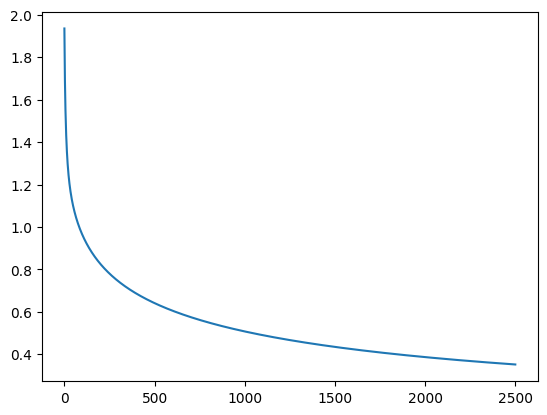

In [11]:
plt.plot(loss_history)

In [12]:
predict_type = np.argmax( predict_func(w,x), axis=0)

actual_type = np.argmax(t, axis=0)

difference = (predict_type != actual_type).sum()

print("错误数：",difference)
print("准确率： ",1 - difference/240)

错误数： 12
准确率：  0.95


In [13]:
# 利用Mini-autograd训练2层前馈神经网络

from Mini_autograd import *

x = x[1:, :]


l1 = Linear(np.random.rand(4, 5))  # 一层维度 4 -> 4
h1 = Sigmoid()
l2 = Linear(np.random.rand(6, 5))  # 二层 4 -> 6
loss = Softmax_MCELoss()

myNN = NN(
    l1,
    h1,
    l2,
    loss,
)

In [14]:
myNN.train(x,t,epoch=2500)

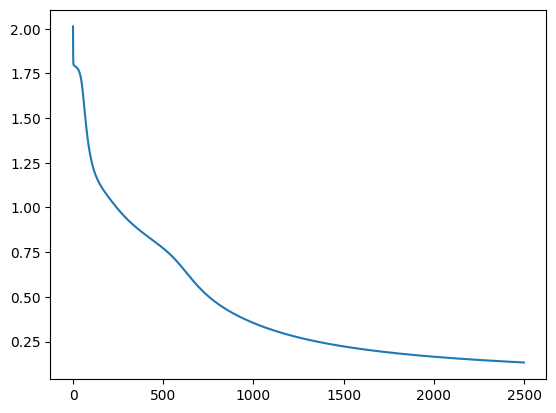

In [15]:
plt.plot(myNN.show_loss_history())

In [16]:
output = myNN.predict(x)

predict_type = np.argmax(output, axis=0)
actual_type = np.argmax(t, axis=0)

difference = (predict_type != actual_type).sum()
print("错误数：",difference)
print("准确率： ",1 - difference/240)

错误数： 5
准确率：  0.9791666666666666
